# Data Cleaning Preprocessing


The goal is to prepare data for EDA by cleaning the data of any issues.
Some data cleaning practices include:
- Reducing memory usage
- Removing duplicate data
- Fixing structural errors
- Identifying missing values

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import missingno


In [2]:
df = pd.read_csv("data/Telecom_customer churn.csv")

## Reducing Memory Usage

In [24]:
# Total memory usage
initial_memory_usage = df.memory_usage(index=False,deep=True).sum() / 1024**2
initial_memory_usage

144933162

In [5]:
# default column datatypes
df.dtypes

rev_Mean       float64
mou_Mean       float64
totmrc_Mean    float64
da_Mean        float64
ovrmou_Mean    float64
                ...   
kid11_15        object
kid16_17        object
creditcd        object
eqpdays        float64
Customer_ID      int64
Length: 100, dtype: object

In order to reduce the total amount of memory usage, we can use a few strategies.

1. Assign new datatypes (ex. float64 -> float16).

dtypes:
- int8 can store integers from -128 to 127.
- int16 can store integers from -32768 to 32767.
- int64 can store integers from -9223372036854775808 to 9223372036854775807.
- object -> numerical or categorical

2. Drop NA

Reducing the total number of records.



In [45]:
# helper function
# Inspired by arjanso  (https://www.kaggle.com/arjanso) """

def reduce_mem_usage(props):
    
    start_mem_usg = props.memory_usage(index=False,deep=True).sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            
            # Integer does not support NA, therefore, NA needs to be filled
            
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
            
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                print("REACHED HERE")
                print(col)
                
                props[col] = props[col].astype(np.float32)
            
            # add back NA values
            if col in NAlist:
                props[col].replace(mn-1,np.nan,inplace=True)

            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
        else:
            num_unique_values = len(props[col].unique())
            num_total_values = len(props[col])
            if num_unique_values / num_total_values < 0.5:
                props.loc[:,col] = props[col].astype('category')
            else:
                props.loc[:,col] = props[col]
            print("dtype after: ",props[col].dtype)
            print("******************************")

    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage(index=False,deep=True).sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print(f"Memory usage reduced by: {100-(100*mem_usg/start_mem_usg):.2f}%")
    return props, NAlist

In [46]:
df, NAlist = reduce_mem_usage(df)

Memory usage of properties dataframe is : 173.4096164703369  MB
******************************
Column:  rev_Mean
dtype before:  float64
REACHED HERE
rev_Mean
dtype after:  float32
******************************
******************************
Column:  mou_Mean
dtype before:  float64
REACHED HERE
mou_Mean
dtype after:  float32
******************************
******************************
Column:  totmrc_Mean
dtype before:  float64
REACHED HERE
totmrc_Mean
dtype after:  float32
******************************
******************************
Column:  da_Mean
dtype before:  float64
REACHED HERE
da_Mean
dtype after:  float32
******************************
******************************
Column:  ovrmou_Mean
dtype before:  float64
REACHED HERE
ovrmou_Mean
dtype after:  float32
******************************
******************************
Column:  ovrrev_Mean
dtype before:  float64
REACHED HERE
ovrrev_Mean
dtype after:  float32
******************************
******************************
Column:

Removing all records that contain NA significantly reduces memory consumption. However, without proper EDA we cannot assume that those records can be dropped

## Removing dupicated data

In [65]:
# check for duplicated records
len(df[df.duplicated()])

# No duplicate records :)

0

## Fixing structural errors

Many of the categorical data has cyptic values. Using the descriptions of each column we can add more descriptive values

In [63]:
cats = list(df.select_dtypes(include=['category']))

In [56]:
# New cellphone user
df["new_cell"].unique()

# Values can mean yes, no, unknown

['U', 'N', 'Y']
Categories (3, object): ['U', 'N', 'Y']

In [57]:
# Credit class code
df["crclscod"].unique()

# 54 class codes

['A', 'EA', 'C', 'B', 'BA', ..., 'EF', 'Z2', 'CY', 'P1', 'ZF']
Length: 54
Categories (54, object): ['A', 'EA', 'C', 'B', ..., 'Z2', 'CY', 'P1', 'ZF']

In [58]:
# Account spending limit
df["asl_flag"].unique()

# Yes or No

['N', 'Y']
Categories (2, object): ['N', 'Y']

In [59]:
# Social group letter only
df["prizm_social_one"].unique()

# 5 social groups

['S', 'U', 'T', 'C', NaN, 'R']
Categories (5, object): ['S', 'U', 'T', 'C', 'R']

In [60]:
# Geographic area
df["area"].unique()

# 19 different locations

['NORTHWEST/ROCKY MOUNTAIN AREA', 'CHICAGO AREA', 'GREAT LAKES AREA', 'NEW ENGLAND AREA', 'DALLAS AREA', ..., 'CALIFORNIA NORTH AREA', 'DC/MARYLAND/VIRGINIA AREA', 'NORTH FLORIDA AREA', NaN, 'LOS ANGELES AREA']
Length: 20
Categories (19, object): ['NORTHWEST/ROCKY MOUNTAIN AREA', 'CHICAGO AREA', 'GREAT LAKES AREA', 'NEW ENGLAND AREA', ..., 'CALIFORNIA NORTH AREA', 'DC/MARYLAND/VIRGINIA AREA', 'NORTH FLORIDA AREA', 'LOS ANGELES AREA']

In [62]:
# Dualband connection
df["dualband"].unique()

# 4 categories
# T -> potentially be "True" = Y

['Y', 'N', 'T', 'U', NaN]
Categories (4, object): ['Y', 'N', 'T', 'U']

In [67]:
# Display all category
for col in cats:
    print(df[col].unique())
    print()

['U', 'N', 'Y']
Categories (3, object): ['U', 'N', 'Y']

['A', 'EA', 'C', 'B', 'BA', ..., 'EF', 'Z2', 'CY', 'P1', 'ZF']
Length: 54
Categories (54, object): ['A', 'EA', 'C', 'B', ..., 'Z2', 'CY', 'P1', 'ZF']

['N', 'Y']
Categories (2, object): ['N', 'Y']

['S', 'U', 'T', 'C', NaN, 'R']
Categories (5, object): ['S', 'U', 'T', 'C', 'R']

['NORTHWEST/ROCKY MOUNTAIN AREA', 'CHICAGO AREA', 'GREAT LAKES AREA', 'NEW ENGLAND AREA', 'DALLAS AREA', ..., 'CALIFORNIA NORTH AREA', 'DC/MARYLAND/VIRGINIA AREA', 'NORTH FLORIDA AREA', NaN, 'LOS ANGELES AREA']
Length: 20
Categories (19, object): ['NORTHWEST/ROCKY MOUNTAIN AREA', 'CHICAGO AREA', 'GREAT LAKES AREA', 'NEW ENGLAND AREA', ..., 'CALIFORNIA NORTH AREA', 'DC/MARYLAND/VIRGINIA AREA', 'NORTH FLORIDA AREA', 'LOS ANGELES AREA']

['Y', 'N', 'T', 'U', NaN]
Categories (4, object): ['Y', 'N', 'T', 'U']

['N', 'R', NaN]
Categories (2, object): ['N', 'R']

['WCMB', 'WC', NaN, 'UNKW']
Categories (3, object): ['WCMB', 'WC', 'UNKW']

['O', NaN, 'R']
Categori

## Identifying missing values

We can visualize which columns suffer greatly from missing data. This will be useful information to do futher EDA, and decide whether to fill or drop the missing values

<AxesSubplot:>

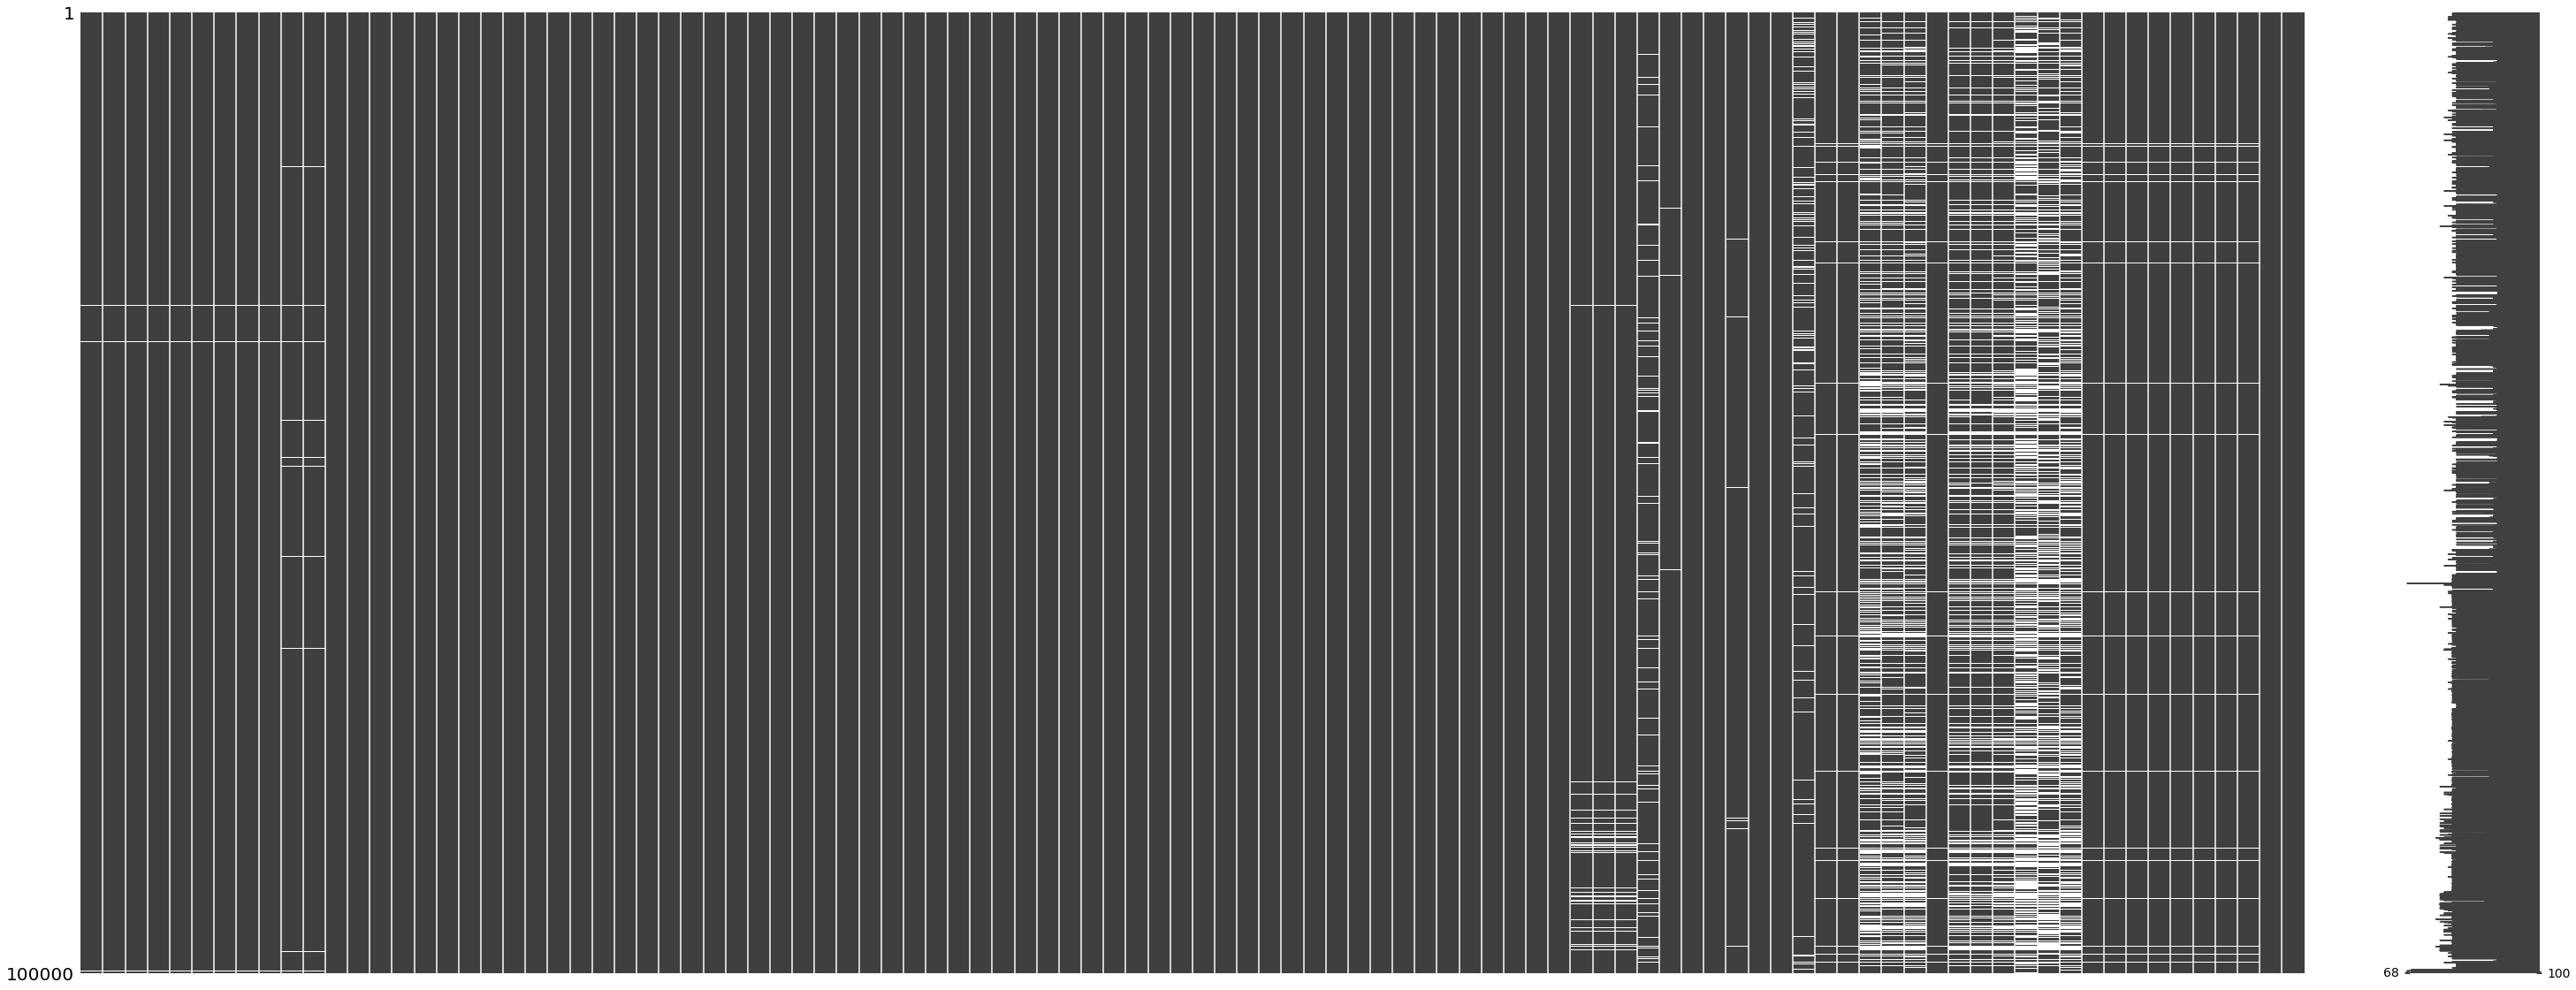

In [4]:
missingno.matrix(df, figsize = (50,20))

In [5]:
df.isnull().sum()

rev_Mean        357
mou_Mean        357
totmrc_Mean     357
da_Mean         357
ovrmou_Mean     357
               ... 
kid11_15       1732
kid16_17       1732
creditcd       1732
eqpdays           1
Customer_ID       0
Length: 100, dtype: int64

In [14]:
df.isnull().sum().nlargest(43)

numbcars            49366
dwllsize            38308
HHstatin            37923
ownrent             33706
dwlltype            31909
lor                 30190
income              25436
adults              23019
infobase            22079
hnd_webcap          10189
prizm_social_one     7388
avg6mou              2839
avg6qty              2839
avg6rev              2839
truck                1732
rv                   1732
marital              1732
forgntvl             1732
ethnic               1732
kid0_2               1732
kid3_5               1732
kid6_10              1732
kid11_15             1732
kid16_17             1732
creditcd             1732
change_mou            891
change_rev            891
hnd_price             847
rev_Mean              357
mou_Mean              357
totmrc_Mean           357
da_Mean               357
ovrmou_Mean           357
ovrrev_Mean           357
vceovr_Mean           357
datovr_Mean           357
roam_Mean             357
area                   40
dualband    

The column numbcars has almost 50% missing data. If we were to drop all NA records we would lose half of our data. Perhaps dropping that column can retain more data from dropping NA records.

# Results

- Memory usage was reduced by 80%
- No duplicate records were found
- Explored some of the category values
- 43 columns have some missing values
    - 88% (38/43) contain a significant amount of missing data